<a href="https://colab.research.google.com/github/BDouchet/SDATA/blob/main/Kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A state-space Problem (Linear Gaussian)

A target in a 2D-plane has a trajectory which is measured by a sensor. The sensor is not really reliable so I want to filter the the observed values to get a better estimation of the trajectory.

> $x_k$ is the vector of the real trajectory such as
$x_k = \begin{bmatrix}
x_k^1 & v_k^1 & x_k^2 & v_k^2 \\
\end{bmatrix}^T$, 
with $x_k^1$ and $x_k^2$ the position of the target according to the axes 1 and 2, and $v_k^1$ and $v_k^2$ the velocity along the two same axes.

>$y_k$ is the observed values through the sensor such as $y_k = \begin{bmatrix}
y_k^1 & y_k^2 \\
\end{bmatrix}^T$,
with $y_k^1$ and $y_k^2$ the observed coordinates along the axis 1 and 2.


**The trajectory $(x_k)$ is defined at each step as follow :**

> $x_k = F * x_{k-1} + u_k$

where $F=\begin{bmatrix}
1 & T_e & 0 & 0 \\0 & 1 & 0 & 0 \\0 & 0 & 1 & T_e \\0 & 0 & 0 & 1
\end{bmatrix}$, 

$u_k \sim N(0_{4,1}, \Sigma_u)$ and 

$\Sigma_u=\sigma^2\begin{bmatrix}
\frac{T_e^3}{3} & \frac{T_e^2}{2} & 0 & 0 \\\frac{T_e^2}{2} & T_e & 0 & 0 \\0 & 0 & \frac{T_e^3}{3} & \frac{T_e^2}{2} \\0 & 0 & \frac{T_e^2}{2} & T_e
\end{bmatrix}$.

**The observed values are created as follow :**

> $y_k = H * x_k + w_k$

where $H=\begin{bmatrix}
1 & 0 & 0 & 0 \\0 & 0 & 1 & 0
\end{bmatrix}$, 


$u_k \sim N(0_{4x1}, \Sigma_u)$ and 

$\Sigma_w=\begin{bmatrix}
\sigma_1^2 & 0 \\ 0 & \sigma_2^2
\end{bmatrix}$.

# Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
Te=1
T=100 # Number of time steps
sgm=1
sgm1=30
sgm2=30

F=np.array([[1,Te,0,0],[0,1,0,0],[0,0,1,Te],[0,0,0,1]])
sgm_u=sgm**2*np.array([[Te**3/3,Te**2/2,0,0],[Te**2/2,Te,0,0],[0,0,Te**3/3,Te**2/2],[0,0,Te**2/2,Te]])
H=np.array([[1,0,0,0],[0,0,1,0]])
sgm_w=np.array([[sgm1**2,0],[0,sgm2**2]])

x0=np.array([[3],[40],[-3],[20]]) # Initial state (position and velocity)

# Generation

`xks` are the $(x_k)$ values.

`yks` are the $(y_k)$ observed values. 

In [6]:
xks=[x0]
for _ in range(T-1):
    xk_last=xks[-1]
    uk=np.random.multivariate_normal(mean=np.zeros(4),cov=sgm_u)
    xk = F @ xk_last + np.expand_dims(uk,1)
    xks.append(xk)
xks=np.array(xks)
xks_final=np.array([xks[:,i,0] for i in range(4)])
xks_final.shape

(4, 100)

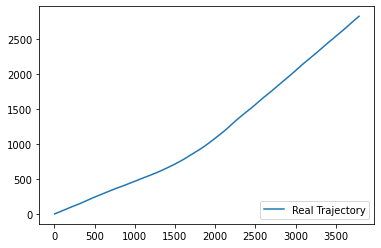

In [8]:
plt.plot(xks_final[0,:],xks_final[2,:],label='Real Trajectory')
plt.legend(loc='lower right')
plt.show()

In [9]:
yks=[]
for i in range(T):
    wk=np.random.multivariate_normal(mean=np.zeros(2),cov=sgm_w)
    yk = H @ xks[i] + np.expand_dims(wk,1)
    yks.append(yk)
yks=np.array(yks)
yks_final=np.array([yks[:,0,0],yks[:,1,0]])
yks_final.shape

(2, 100)

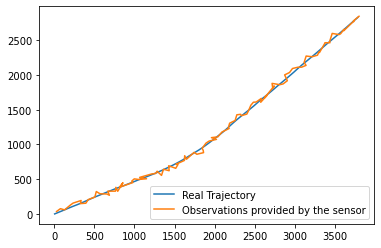

In [10]:
plt.plot(xks_final[0,:],xks_final[2,:],label='Real Trajectory')
plt.plot(yks_final[0,:],yks_final[1,:],label='Observations provided by the sensor')
plt.legend(loc='lower right')
plt.show()

# Kalman Filter

## Mathematical Background

The Karman Filter is composed of two steps : 

**Prediction**

> $p(x_k|y_{1:k-1})=\int{p(x_k|x_{k-1})
p(x_{k-1}|y_{1:k-1})dx{k-1}}$

**Update**

> $p(x_k|y_{1:k}) = \frac{p(y_k|x_k)p(x_k|y_{1:k-1})}{p(y_k|y_{1:k-1})}$ 


Because we assume that $p(x_{k-1}|y_{1:k-1} = N(\hat{x}_{k-1|k-1},P_{k-1|k-1})$, 

## Implementation

In [70]:
xm_0_0=x0
P_0_0=np.eye(4)

def predict(x_k1_k1,P_k1_k1):
    x_k_k1 = F @ x_k1_k1
    P_k_k1 = F @ P_k1_k1 @ F.T + sgm_u
    return x_k_k1,P_k_k1

def update(x_k_k1,P_k_k1,y_k):
    K = P_k_k1 @ H.T @ np.linalg.inv(H @ P_k_k1 @ H.T + sgm_w)
    x_k_k = x_k_k1 + K @ (y_k - H @ x_k_k1)
    P_k_k = (np.eye(4) - K @ H) @ P_k_k1
    return x_k_k, P_k_k

xms=[xm_0_0]
Ps=[P_0_0]
for i in range(T-1):
    x_k1_k1=xms[-1]
    P_k1_k1=Ps[-1]
    x_k_k1, P_k_k1 = predict(x_k1_k1, P_k1_k1)
    x_k_k, P_k_k = update(x_k_k1, P_k_k1, yks[i+1])
    xms.append(x_k_k)
    Ps.append(P_k_k)
xms=np.array(xms)
Ps=np.array(Ps)
xms_final=np.array([xms[:,i,0] for i in range(4)])
xms_final.shape

(4, 100)

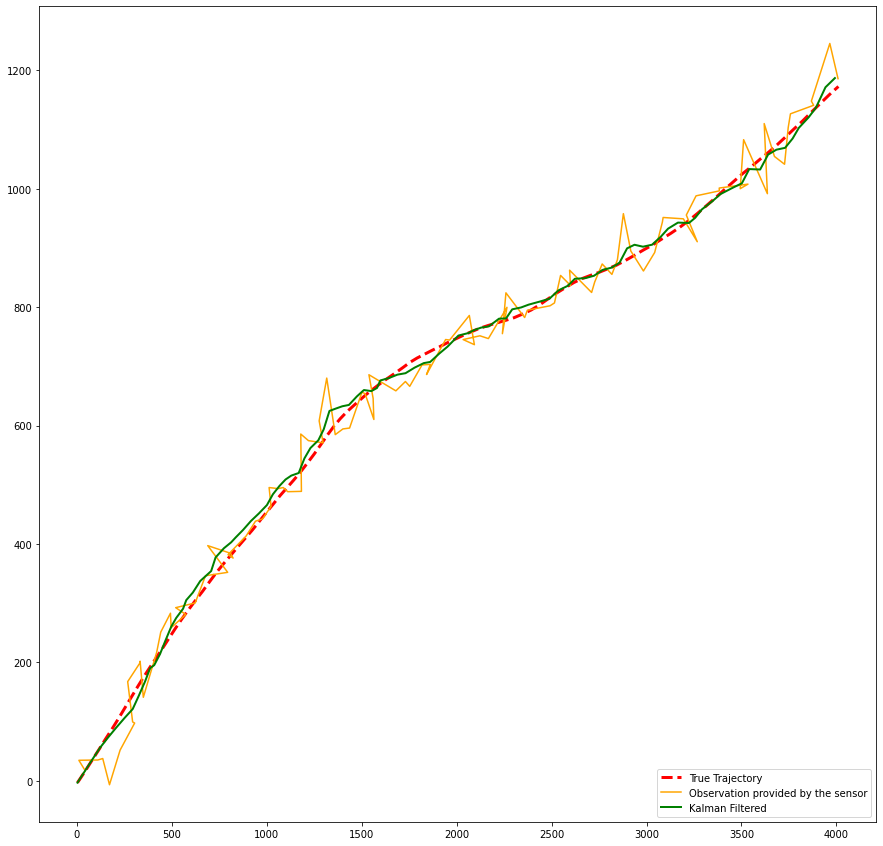

In [89]:
plt.figure(figsize=(15,15))
plt.plot(xks_final[0,:],xks_final[2,:],linewidth=3,linestyle='--',color='red',label='True Trajectory')
plt.plot(yks_final[0,:],yks_final[1,:],color='orange',label='Observation provided by the sensor')
plt.plot(xms_final[0,:],xms_final[2,:],color='green',linewidth=2,label='Kalman Filtered')
plt.legend(loc='lower right')
plt.show()

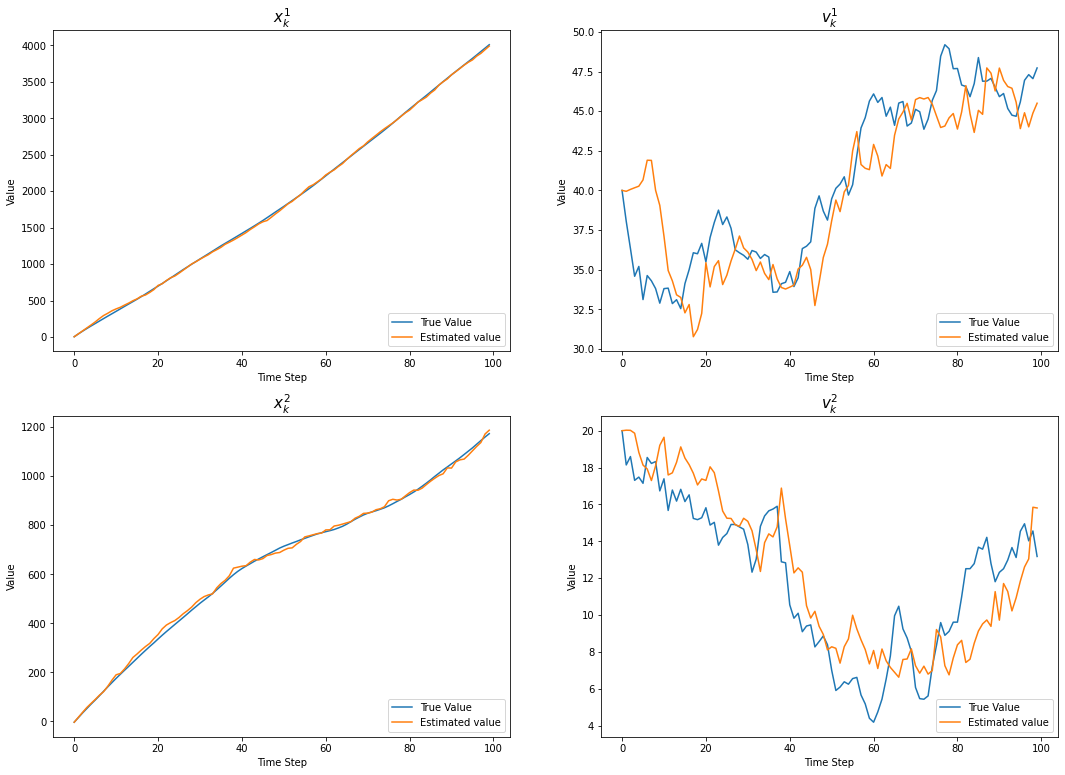

In [96]:
names=['$x_k^1$','$v_k^1$','$x_k^2$','$v_k^2$']
_,axs=plt.subplots(ncols=2,nrows=2,figsize=(18,13))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.plot(xks_final[i,:],label='True Value')
    plt.plot(xms_final[i,:],label='Estimated value')
    plt.legend(loc='lower right')
    plt.title(names[i],fontsize=15)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
plt.show()

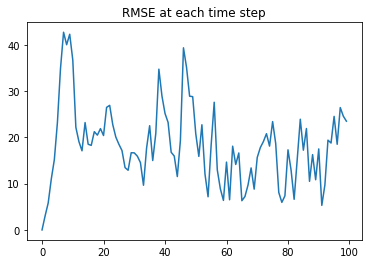

RMSE over all the time steps : 18.371579654817783


In [101]:
def rmse(true,pred):
    return ((true-pred).T @ (true-pred))**0.5
plt.plot([rmse(xks_final[:,i],xms_final[:,i]) for i in range(T)])
plt.title('RMSE at each time step')
plt.show()
print('RMSE over all the time steps : '+str(np.average([rmse(xks_final[:,i],xms_final[:,i]) for i in range(T)])))

# Same with differents parameters

In [102]:
def all_process(Te=1, T=100, sgm=1, sgm1=30, sgm2=30,x0=np.array([[3],[40],[-3],[20]])):

    #Initialization constants
    F=np.array([[1,Te,0,0],[0,1,0,0],[0,0,1,Te],[0,0,0,1]])
    sgm_u=sgm**2*np.array([[Te**3/3,Te**2/2,0,0],[Te**2/2,Te,0,0],[0,0,Te**3/3,Te**2/2],[0,0,Te**2/2,Te]])
    H=np.array([[1,0,0,0],[0,0,1,0]])
    sgm_w=np.array([[sgm1**2,0],[0,sgm2**2]])
    xm_0_0=x0
    P_0_0=np.eye(4)

    xks=[x0]
    yks=[H @ xks[0] + np.expand_dims(np.random.multivariate_normal(mean=np.zeros(2),cov=sgm_w),1)]
    xms=[xm_0_0]

    for _ in range(T-1):
        xk_last=xks[-1]
        uk=np.random.multivariate_normal(mean=np.zeros(4),cov=sgm_u)
        xk = F @ xk_last + np.expand_dims(uk,1)
        xks.append(xk)

        wk=np.random.multivariate_normal(mean=np.zeros(2),cov=sgm_w)
        yk = H @ xk + np.expand_dims(wk,1)
        yks.append(yk)

        x_k1_k1=xms[-1]
        P_k1_k1=Ps[-1]
        x_k_k1, P_k_k1 = predict(x_k1_k1, P_k1_k1)
        x_k_k, P_k_k = update(x_k_k1, P_k_k1, yk)
        xms.append(x_k_k)

    xks=np.array(xks)
    xks_final=np.array([xks[:,i,0] for i in range(4)])
        
    yks=np.array(yks)
    yks_final=np.array([yks[:,0,0],yks[:,1,0]])

    xms=np.array(xms)
    xms_final=np.array([xms[:,i,0] for i in range(4)])

    return xks_final, yks_final, xms_final

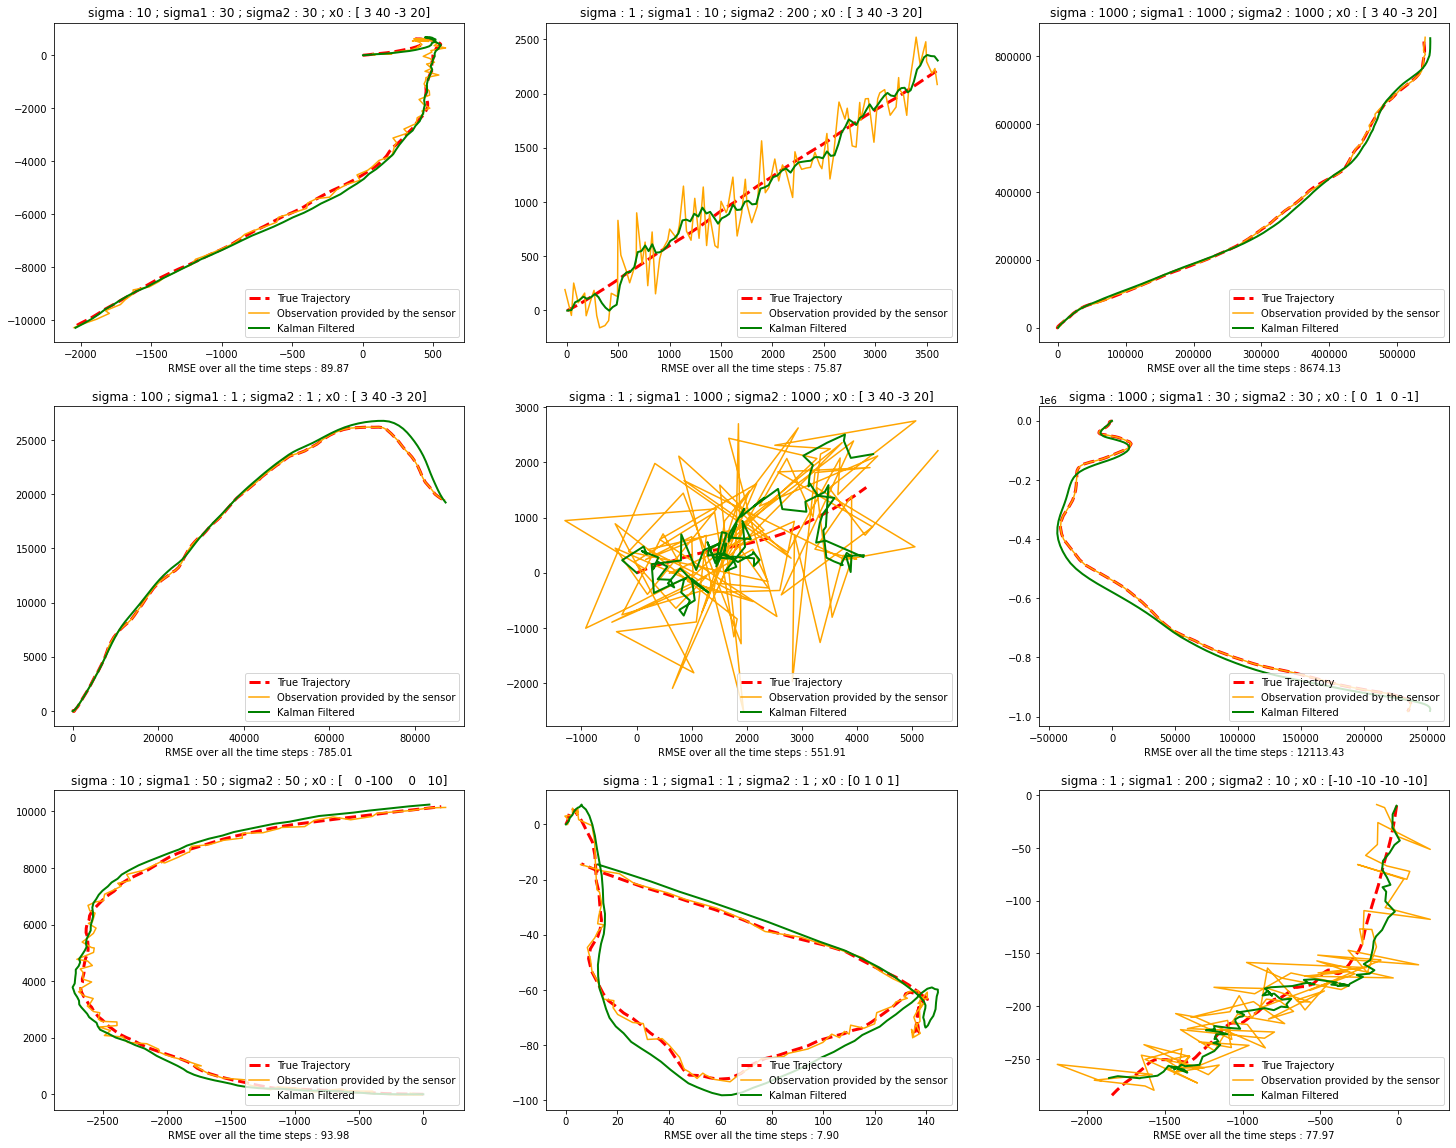

In [110]:
initializers=[[10,30,30,np.array([[3],[40],[-3],[20]])],
              [1,10,200,np.array([[3],[40],[-3],[20]])],
              [1000,1000,1000,np.array([[3],[40],[-3],[20]])],
              [100,1,1,np.array([[3],[40],[-3],[20]])],
              [1,1000,1000,np.array([[3],[40],[-3],[20]])],
              [1000,30,30,np.array([[0],[1],[0],[-1]])],
              [10,50,50,np.array([[0],[-100],[0],[10]])],
              [1,1,1,np.array([[0],[1],[0],[1]])],
              [1,200,10,np.array([[-10],[-10],[-10],[-10]])]]

_,axs=plt.subplots(ncols=3,nrows=3,figsize=(25,20))

for i,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    xks_final,yks_final,xms_final=all_process(Te=1,T=100,sgm=initializers[i][0],
                                              sgm1=initializers[i][1],sgm2=initializers[i][2],x0=initializers[i][3])
    plt.plot(xks_final[0,:],xks_final[2,:],linewidth=3,linestyle='--',color='red',label='True Trajectory')
    plt.plot(yks_final[0,:],yks_final[1,:],color='orange',label='Observation provided by the sensor')
    plt.plot(xms_final[0,:],xms_final[2,:],color='green',linewidth=2,label='Kalman Filtered')
    plt.title('sigma : '+str(initializers[i][0])+' ; sigma1 : '+str(initializers[i][1])+' ; sigma2 : '+str(initializers[i][2])+' ; x0 : '+str(np.reshape(initializers[i][3],(4))))
    plt.xlabel('RMSE over all the time steps : %.2f' % np.average([rmse(xks_final[:,i],xms_final[:,i]) for i in range(T)]))
    plt.legend(loc='lower right')
plt.show()